<center><h1>Escenarios experimentales Internetworking</h1></center>

Presentado por: Rodney Christopher Armas Vacas
Fecha: 23/02/2023

# Importación de librerias necesarias

In [1]:
#This repo is to share the code shared during the TechGig webinar. 
#We have used a dataset taken from Canadian Institute of CyberSecurity. 
#We cannot share the data here; please contact a.habibi.l@unb.ca to obtain the dataset.
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Cargar el Dataset

In [2]:
datapath = 'https://raw.githubusercontent.com/hfcatucuamba/proyectoInternetworking/main/Escenario1.csv'
dataframe = pd.read_csv(datapath,low_memory=False, sep=';')

# Normalizar los datos

In [3]:
def dfNormalize(df):
    for feature_name in df.columns:
        df.loc[:,feature_name]= pd.to_numeric(df.loc[:,feature_name], errors='coerce').fillna(0)
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()   
        if (max_value - min_value) > 0:
            df.loc[:,feature_name] = (df.loc[:,feature_name] - min_value) / (max_value - min_value)
        else:
            df.loc[:,feature_name] = (df.loc[:,feature_name]- min_value)    
    return df

In [4]:
print (dataframe.shape)
dataframe = dataframe.reindex(np.random.permutation(dataframe.index)).copy()
print(dataframe.describe())
print (list(dataframe))

(7000, 29)
        Source Port   Destination Port   Protocol   Flow Duration  \
count   7000.000000        7000.000000     7000.0    7.000000e+03   
mean   42153.076571        7647.390714        6.0    4.002204e+06   
std    17081.978193       17168.713987        0.0    4.450485e+06   
min       80.000000          21.000000        6.0    1.700000e+01   
25%    38894.000000         443.000000        6.0    2.013598e+05   
50%    45337.000000         443.000000        6.0    4.409195e+05   
75%    54698.000000         443.000000        6.0    9.829612e+06   
max    61156.000000       65514.000000        6.0    1.000000e+07   

        Flow IAT Max   Flow IAT Min   Fwd IAT Max   Fwd IAT Min   Bwd IAT Max  \
count   7.000000e+03   7.000000e+03  7.000000e+03  7.000000e+03  7.000000e+03   
mean    1.148187e+06   1.023332e+05  1.079414e+06  1.035305e+05  8.884348e+05   
std     2.113319e+06   4.321051e+05  2.135818e+06  6.952060e+05  1.933856e+06   
min     1.700000e+01  -4.340000e+02  0.0000

In [5]:
keys = dataframe.keys()
# Feature Selection, Dropping Source IP, Source Port, Destination IP and Destination Port as it 
# specific to each organisation network and generic model should not contain them. 
data_to_process = dataframe[keys[4:len(keys) - 1]].copy()
#data_to_process = dataframe[[' Source Port',' Destination Port', ' Flow Duration', ' Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean','Fwd IAT Mean','Bwd IAT Mean','Active Mean','Idle Mean','label']].copy()
# do a data normalization
x_normalised = dfNormalize(data_to_process)
print(x_normalised.describe())

        Protocol   Flow Duration   Flow Bytes/s   Flow Packets/s  \
count     7000.0     7000.000000    7000.000000      7000.000000   
mean         0.0        0.400219       0.000143         0.000167   
std          0.0        0.445049       0.011952         0.012051   
min          0.0        0.000000       0.000000         0.000000   
25%          0.0        0.020134       0.000000         0.000000   
50%          0.0        0.044090       0.000000         0.000000   
75%          0.0        0.982961       0.000000         0.000000   
max          0.0        1.000000       1.000000         1.000000   

        Flow IAT Mean   Flow IAT Std   Flow IAT Max   Flow IAT Min  \
count     7000.000000         7000.0    7000.000000    7000.000000   
mean         0.017407            0.0       0.114853       0.010376   
std          0.055836            0.0       0.211398       0.043627   
min          0.000000            0.0       0.000000       0.000000   
25%          0.000000            0.0 

In [6]:
change_labels = lambda x: 1 if x == 'nonTOR' else 0

In [7]:
y_normalised = dataframe['label'].apply(change_labels)

# Obtener los datos para entrenar y de prueba¶

In [8]:
X_train, X_test, y_train, y_test = train_test_split(x_normalised,
                                            y_normalised, test_size=0.3, random_state=42)

# Creación modelo

In [9]:
# Crear el modelo de DNN
# Function to create model, required for KerasClassifier
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Crear modelo DNN
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compilar modelo
model.compile(optimizer="adam",
              loss="binary_crossentropy", 
              metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1600      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,713
Trainable params: 3,713
Non-trainable params: 0
_________________________________________________________________


In [10]:
batch_size = 32
steps_per_epoch = (X_train.shape[0]//batch_size)
validation_steps = (x_normalised.shape[0] // batch_size)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

In [11]:
%%time

model.fit(X_train, y_train, batch_size=32, epochs=35, validation_data=(X_test, y_test))

Epoch 1/35
154/154 [==============================] - 2s 7ms/step - loss: 0.3741 - accuracy: 0.9120 - val_loss: 0.2116 - val_accuracy: 0.9152
Epoch 2/35
154/154 [==============================] - 1s 4ms/step - loss: 0.1741 - accuracy: 0.9306 - val_loss: 0.1408 - val_accuracy: 0.9424
Epoch 3/35
154/154 [==============================] - 1s 5ms/step - loss: 0.1199 - accuracy: 0.9545 - val_loss: 0.1025 - val_accuracy: 0.9600
Epoch 4/35
154/154 [==============================] - 1s 5ms/step - loss: 0.0837 - accuracy: 0.9722 - val_loss: 0.0761 - val_accuracy: 0.9776
Epoch 5/35
154/154 [==============================] - 1s 5ms/step - loss: 0.0658 - accuracy: 0.9822 - val_loss: 0.0640 - val_accuracy: 0.9829
Epoch 6/35
154/154 [==============================] - 1s 5ms/step - loss: 0.0568 - accuracy: 0.9841 - val_loss: 0.0573 - val_accuracy: 0.9838
Epoch 7/35
154/154 [==============================] - 1s 5ms/step - loss: 0.0517 - accuracy: 0.9845 - val_loss: 0.0534 - val_accuracy: 0.9848
Epoch 

In [12]:
loss, accuracy = model.evaluate(X_test,y_test,batch_size=batch_size)
# Evaluar el modelo
print('test_loss: %.2f' % (loss * 100.0))  
print('test_accuracy: %.2f' % (accuracy * 100.0))

66/66 [==============================] - 0s 3ms/step - loss: 0.0339 - accuracy: 0.9886
test_loss: 3.39
test_accuracy: 98.86


In [13]:
# Hacer predicciones sobre los datos de prueba
y_pred = model.predict(X_test)

# Convertir las probabilidades en etiquetas binarias (0 o 1) usando un umbral de 0.5
y_pred_binary = (y_pred > 0.5).astype(int)

# Importar métricas de sklearn
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Calcular métricas
acc = accuracy_score(y_test, y_pred_binary)*100
f1 = f1_score(y_test, y_pred_binary)*100
prec = precision_score(y_test, y_pred_binary)*100
rec = recall_score(y_test, y_pred_binary)*100

# Imprimir métricas
print("Accuracy:", acc)
print("F1 Score:", f1)
print("Precision:", prec)
print("Recall:", rec)

66/66 [==============================] - 0s 2ms/step
Accuracy: 98.85714285714286
F1 Score: 98.8593155893536
Precision: 97.92843691148776
Recall: 99.80806142034548


## Grafico Roc Curve

66/66 [==============================] - 0s 3ms/step


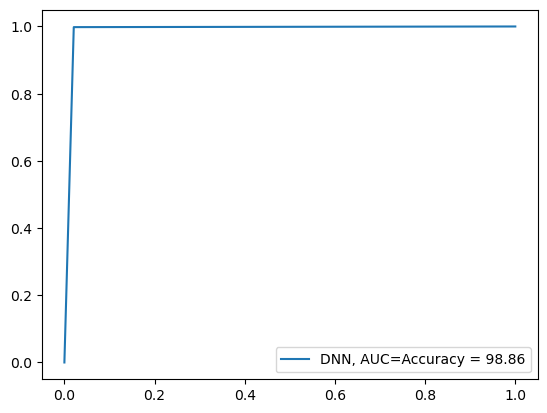

In [14]:
import matplotlib.pyplot as plt
from sklearn import metrics
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
accuracy = metrics.accuracy_score(y_test, y_pred)
CNN = "Accuracy = {:.2f}".format(accuracy*100)
plt.plot(fpr, tpr, label="DNN, AUC=" + str(CNN))
plt.legend()